# Land cover and urban heat islands

## Background

### Land cover
This notebook uses DEA Land Cover data. DEA Land Cover provides annual land cover classification for Australia using the Food and Agriculture Organisation Land Cover Classification System taxonomy. The dataset divides the landscape into six base land cover types:

* 111: Cultivated Terrestrial Vegetation (CTV)
* 112: (Semi-)Natural Terrestrial Vegetation (NTV) 
* 124: Natural Aquatic Vegetation (NAV)
* 215: Artificial Surface (AS)
* 216: Natural Bare Surface (NS)
* 220: Water


### Urban heat islands
Urban areas often experience higher temperatures than their rural surroundings, known as the urban heat island effect (UHI). Impervious surfaces in cities, such as buildings and pavement, are effective at accumulating and trapping heat. This heat is slowly released back into the environment at night, reducing nighttime cooling relief during summer. Other factors can further enhance UHI: cities lacking green infrastructure, such as trees, do not benefit from cooling through shade and evapotranspiration; rainwater directed away from cities becomes unavailable for soil-based evaporative cooling; and heat generated from human activities, such as transport and manufacturing.

UHI can be defined in different ways based on how energy is exchanged, scale variations, and how data is collected. The most accurate way to analyse UHI is by using air temperature, which is measured 2 meters above the ground. This height ensures that the ambient air temperature is captured independently of surface temperatures. Very few areas record air temperature, making large scale UHI analysis difficult. Many studies  overcome this problem by using land surface temperature (LST). LST data is readily available using remotely sensed data and provides a much cheaper alternative to recording field data. LST varies throughout the day, but are most similar to air temperatures in the morning. Therefore, studies that use LST note that it is only an appropriate measure for identifying spatial variations at a point in time as an indicator of UHI only.

In this notebook, we will use land cover/land use data and surface temperature data to understand this phenomenon. 

## Description
In this notebook we will: 

1. Load land cover and surface temperature data.
2. Investigate the relationship between land cover and surface temperature. 
3. Investigate the relationship between land cover and surface temperature at a suburban scale. 

***

## Start analysis

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from matplotlib import colors as mcolours
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import pystac_client
import planetary_computer
import odc.stac
import odc.geo.xr
from odc.geo.geom import BoundingBox
from shapely.geometry import box
import rioxarray
from rasterio.features import geometry_mask
from matplotlib.lines import Line2D


import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import display_map
from dea_tools.landcover import plot_land_cover

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='DEA_notebooks_template')

### Select a study area

In [3]:
# Coordinates for the Adelaide city center  
lat = -34.9232
lon = 138.6004
lat_buffer = 0.2
lon_buffer = 0.2

# Combine central coordinates with buffer values to create the latitude and longitude range for the analysis
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

display_map(x=lon_range, y=lat_range)

### Load land cover data

In [4]:
query = {
    "y": lat_range,
    "x": lon_range,
    "time": "2020",
}

# Load DEA Land Cover data from the datacube
ds_lc = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements="level3",
    resolution=(-25, 25),
    **query
)

# Inspect the data
ds_lc

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 1, y: 1854, x: 1549)
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-01-01
  * y            (y) float64 15kB -3.806e+06 -3.806e+06 ... -3.852e+06
  * x            (x) float64 12kB 5.817e+05 5.817e+05 ... 6.204e+05 6.204e+05
    spatial_ref  int32 4B 3577
Data variables:
    level3       (time, y, x) uint8 3MB 220 220 220 220 220 ... 112 112 111 112
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load surface temperature data

In [5]:
# Open a client pointing to the Microsoft Planetary Computer data catalogue
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [6]:
# Convert data-cube style queries into something readable by `pystac_client`
bbox = BoundingBox.from_xy(lon_range, lat_range)
time_range = '2019-11/2020-02'

# Search for STAC items, filtering to Landsat 8 data only
search = catalog.search(
    collections="landsat-c2-l2",
    bbox=bbox,
    datetime=time_range,
    query={
        "platform": {"in": ["landsat-8"]},
    },
)

# Check how many items were returned
items = search.item_collection()
print(f"Found {len(items)} STAC items")

Found 22 STAC items


Depending on how many STAC items your query has found, it may take a few minutes to run the next two cells. 

In [7]:
# Load Landsat surface temperature data with ODC STAC
ds_temp = odc.stac.load(
    items,
    bbox=bbox,
    bands=["lwir11"],
    crs="EPSG:3577",
    resolution=30,
    groupby="solar_day",
)

# Inspect outputs
ds_temp

<xarray.Dataset> Size: 60MB
Dimensions:      (y: 1546, x: 1291, time: 15)
Coordinates:
  * y            (y) float64 12kB -3.806e+06 -3.806e+06 ... -3.852e+06
  * x            (x) float64 10kB 5.817e+05 5.817e+05 ... 6.204e+05 6.204e+05
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 120B 2019-11-06T00:40:07.154104 ... 20...
Data variables:
    lwir11       (time, y, x) uint16 60MB 41869 41872 41874 41876 ... 0 0 0 0

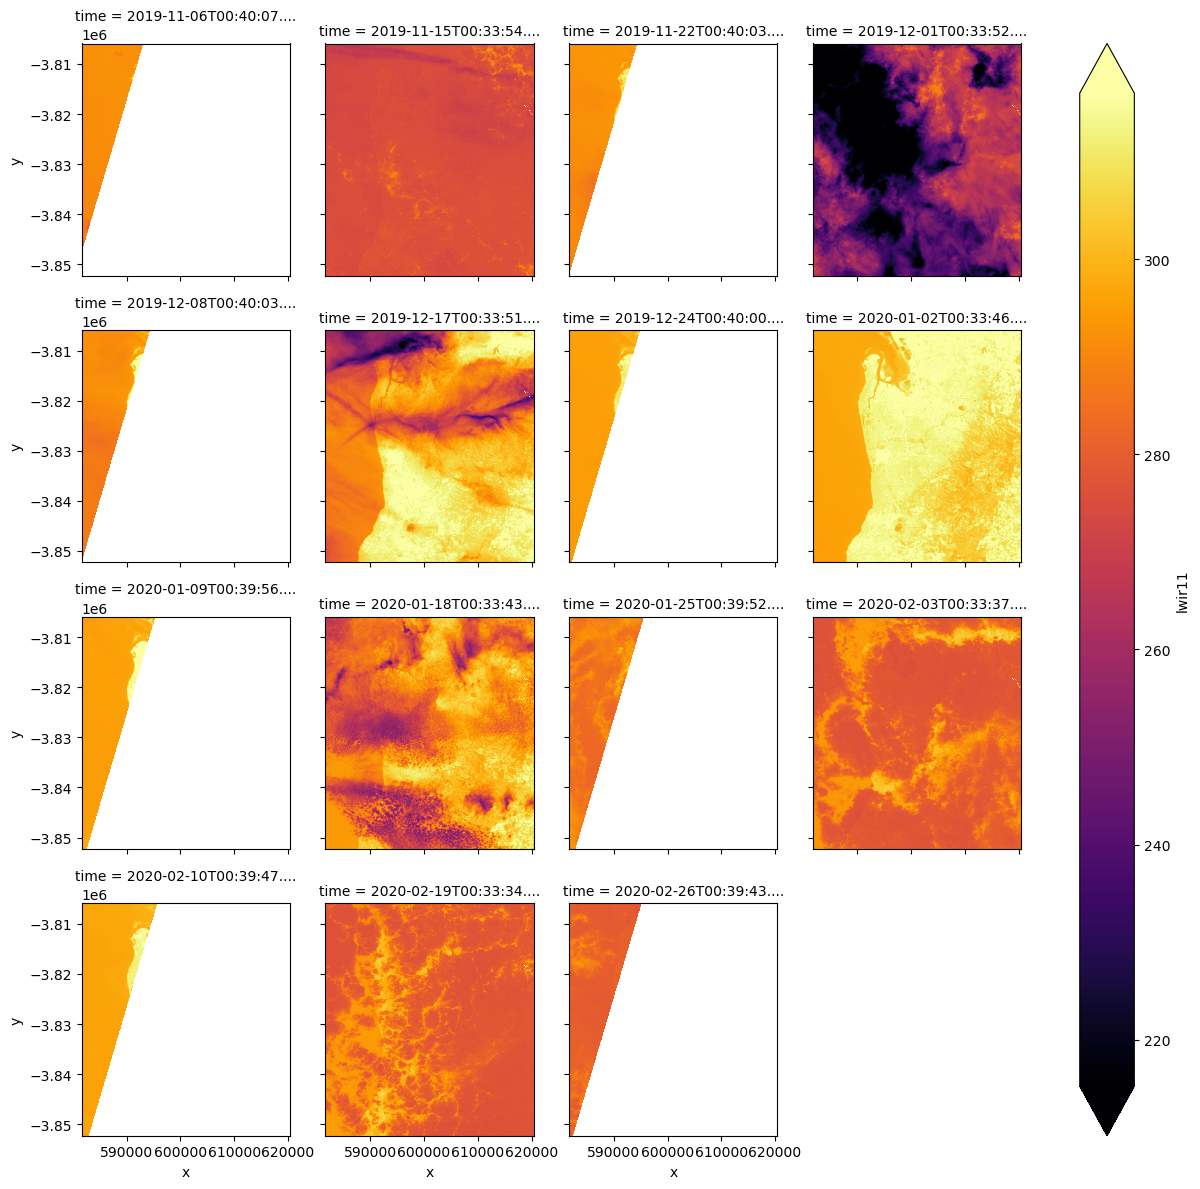

In [8]:
# First set 0 values to nodata
ds_temp = ds_temp.where(ds_temp != 0)

# Apply USGS Collection 2 surface temperature scaling factors to obtain
# temperature in degrees Kelvin
ds_temp = ds_temp * 0.00341802 + 149.0

# Plot our temperature outputs
ds_temp.lwir11.plot.imshow(col="time", col_wrap=4, cmap="inferno", robust=True)

In [9]:
# convert to celsius
temp = ds_temp.isel(time=7)
temp = temp - 273.15
temp

<xarray.Dataset> Size: 8MB
Dimensions:      (y: 1546, x: 1291)
Coordinates:
  * y            (y) float64 12kB -3.806e+06 -3.806e+06 ... -3.852e+06
  * x            (x) float64 10kB 5.817e+05 5.817e+05 ... 6.204e+05 6.204e+05
    spatial_ref  int32 4B 3577
    time         datetime64[ns] 8B 2020-01-02T00:33:46.454448
Data variables:
    lwir11       (y, x) float32 8MB 24.01 24.02 24.04 24.05 ... 39.34 39.4 39.33

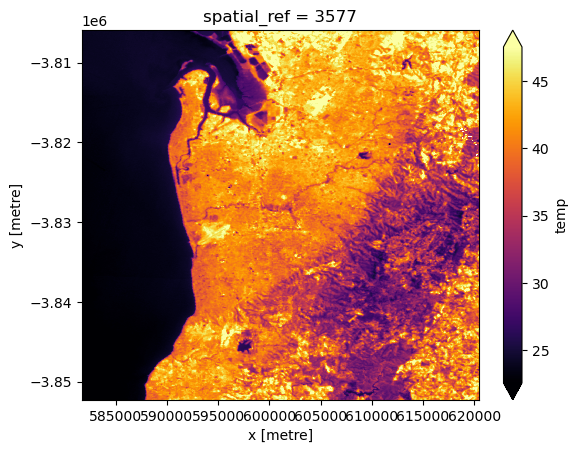

In [10]:
temp = temp.interp(x=ds_lc['x'], y=ds_lc['y'])

ds_lc = ds_lc.assign(temp=temp['lwir11'])

ds_lc.temp.plot.imshow(cmap="inferno", robust=True)

### Plot the data side by side

In [11]:
landcover_colour_scheme = {
    0: (255, 255, 255, 255, "No Data"),
    111: (172, 188, 45, 255, "Cultivated terrestrial vegetation"),
    112: (14, 121, 18, 255, "Natural terrestrial vegetation"),
    124: (30, 191, 121, 255, "Natural aquatic vegetation"),
    215: (218, 92, 105, 255, "Artificial surface"),
    216: (243, 171, 105, 255, "Natural bare surface"),
    220: (77, 159, 220, 255, "Water"),
}

def plot_layer(colours, data, ax):
    colour_arr = [np.array(value[:-2]) / 255 for value in colours.values()]
    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours.keys())
    bounds.append(bounds[-1] + 1)
    norm = mcolours.BoundaryNorm(bounds, cmap.N)
    labels = {
        'ticks': list(colours.keys()),
        'format': '%d'
    }
    im = data.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True, cbar_kwargs=labels)
    # ax.invert_yaxis()
    return im


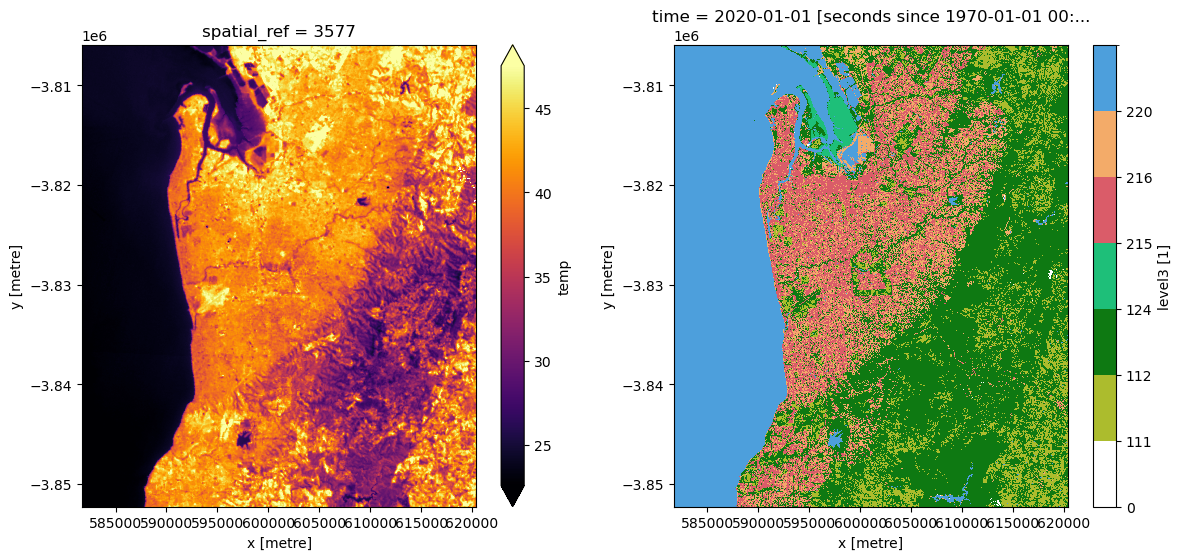

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

ax1.set_title('Temp')
ds_lc.temp.plot.imshow(ax=ax1, cmap="inferno", robust=True)

ax2.set_title('Land Cover')
plot_layer(landcover_colour_scheme, ds_lc.level3, ax=ax2)

### Class analysis


In [13]:
land_cover = ds_lc['level3']
temperature = ds_lc['temp']

data = xr.Dataset({'land_cover': land_cover, 'temperature': temperature})
average_temp_by_class = data.groupby('land_cover').mean()

df = average_temp_by_class['temperature'].to_dataframe().reset_index()
df = df.drop(columns='spatial_ref')
df_filtered = df[df['land_cover'] != 0].copy()

land_cover_names = {
    111: 'Cultivated Areas',
    112: 'Terrestrial Vegetation',
    124: 'Aquatic Vegetation',
    215: 'Artificial Surface',
    216: 'Bare Surface',
    220: 'Water'
}

df_filtered['land_cover'] = df_filtered['land_cover'].map(land_cover_names)
df_filtered = df_filtered[['land_cover', 'temperature']]

df_filtered

,land_cover,temperature
1,Cultivated Areas,41.733924
2,Terrestrial Vegetation,37.054953
3,Aquatic Vegetation,29.551600
4,Artificial Surface,41.709889
5,Bare Surface,41.335941
6,Water,24.138603


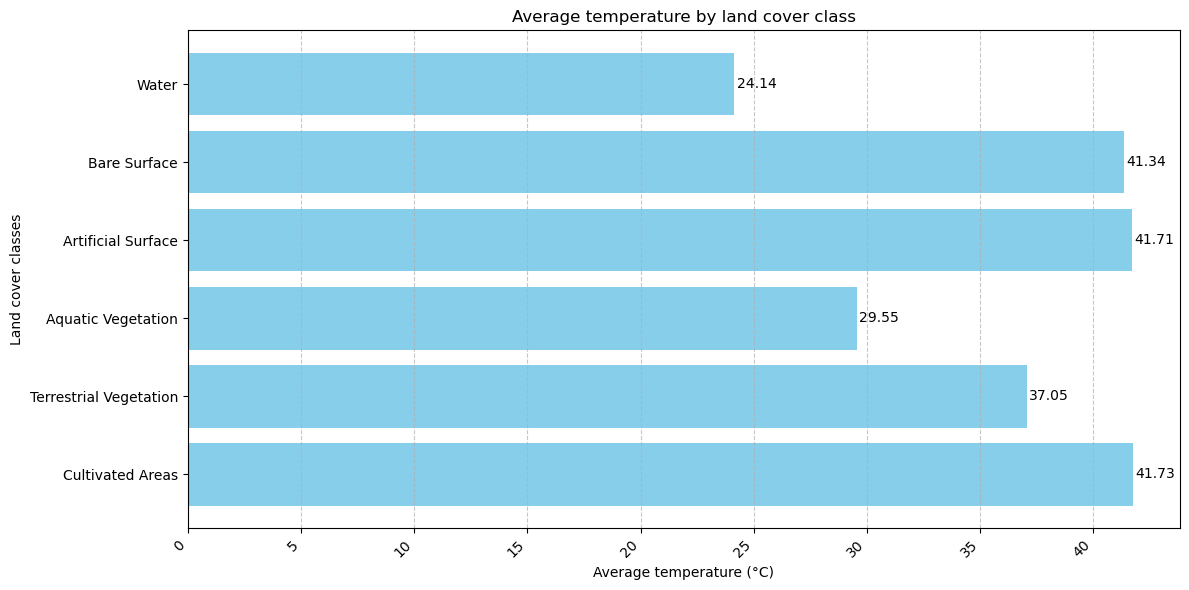

In [14]:
plt.figure(figsize=(12, 6))
bars = plt.barh(df_filtered['land_cover'], df_filtered['temperature'], color='skyblue')
plt.ylabel('Land cover classes')
plt.xlabel('Average temperature (°C)')
plt.title('Average temperature by land cover class')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center')
plt.tight_layout()
plt.show()

### Suburb analysis
Statistical Area Level 2 (SA2) are medium-sized general purpose areas built to represent communities that interact together socially and economically. In the major cities, SA2s often represent single suburbs. 

<Axes: >

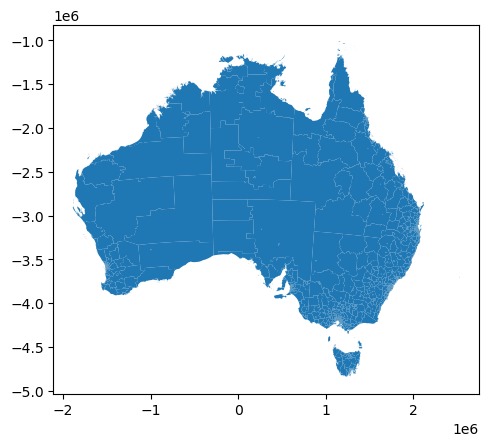

In [15]:
# read in data
data_sa2 = "https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/abs_shapefiles/SA2_2021_Country.zip"
gdf_sa2= gpd.read_file(data_sa2)
gdf_sa2 = gdf_sa2.to_crs(epsg=3577)
gdf_sa2 = gdf_sa2.drop(columns=['SA2_CODE21', 'SA4_NAME21', 'SA3_CODE21', 'GCC_CODE21', 'SA3_NAME21', 
                                'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'SA4_CODE21', 
                                'AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21', 'MinSimpTol', 'Population', 
                                'Dwellings'])
gdf_sa2.plot()

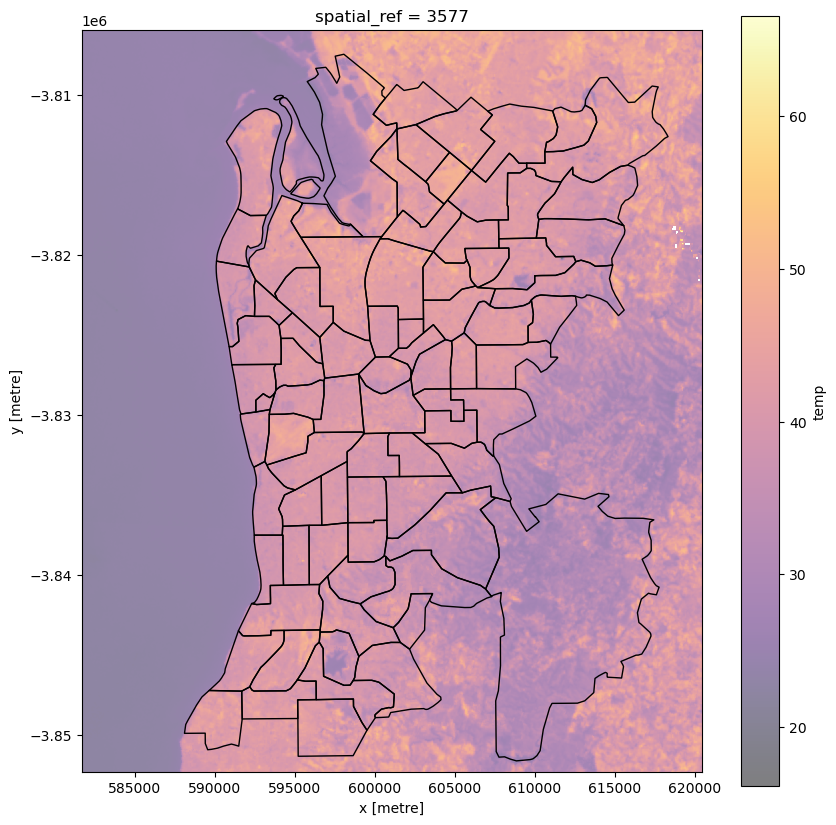

In [16]:
# get the bounding box of the temp data
minx, maxx = ds_lc.x.min().item(), ds_lc.x.max().item()
miny, maxy = ds_lc.y.min().item(), ds_lc.y.max().item()
bbox = box(minx, miny, maxx, maxy)

# clip the shapefiles to the temperature data extent
gdf_clipped = gdf_sa2[gdf_sa2.within(bbox)].copy()

fig, ax = plt.subplots(figsize=(10, 10))
temperature = ds_lc.temp
temperature.plot(ax=ax, cmap='inferno', alpha=0.5)
gdf_clipped.boundary.plot(ax=ax, color='black', linewidth=1)
plt.show()

In [17]:
# aggregate surface temp data over each suburb

temperature = ds_lc.temp
avg_temperatures = []

# loop through each segment in the shapefile
for idx, row in gdf_clipped.iterrows():
    # mask the temp data using the segment geometry
    masked_temp = temperature.rio.clip([row['geometry']], all_touched=True, drop=False)
    
    # cal the average temp
    avg_temp = masked_temp.mean().item()
    
    # save result
    avg_temperatures.append(avg_temp)

# add avg temp to data 
gdf_clipped['avg_temperature'] = avg_temperatures

# print
pd.set_option('display.max_rows', None)
gdf_sorted = gdf_clipped.sort_values(by='avg_temperature', ascending=False)
gdf_sorted[['SA2_NAME21', 'avg_temperature']].head()

,SA2_NAME21,avg_temperature
1752,Parafield,46.901522
1816,Adelaide Airport,44.232846
1754,Paralowie,43.984102
1747,Northgate - Northfield,43.707131
1814,The Parks,43.684026


In [18]:
# aggregate land cover over each suburb
land_cover = ds_lc['level3']  

most_common_land_cover = []
count_111 = []
count_112 = []
count_124 = []
count_215 = []
count_216 = []
count_220 = []

# loop through each segment in the shapefile
for idx, row in gdf_clipped.iterrows():
    # mask land cover data using the segment geometry
    masked_lc = land_cover.rio.clip([row['geometry']], all_touched=True, drop=False)
    
    # flatten and remove NaN and zero values
    masked_lc_values = masked_lc.values.flatten()
    masked_lc_values = masked_lc_values[~np.isnan(masked_lc_values)]
    masked_lc_values = masked_lc_values[masked_lc_values != 0]
    
    # calculate the most common land cover class
    if len(masked_lc_values) > 0:
        values, counts = np.unique(masked_lc_values, return_counts=True)
        mode_lc = values[np.argmax(counts)]
    else:
        mode_lc = np.nan 
    most_common_land_cover.append(mode_lc)
    
    # count occurrences of each specific land cover class
    counts_dict = {111: 0, 112: 0, 124: 0, 215: 0, 216: 0, 220: 0}
    for value in masked_lc_values:
        if value in counts_dict:
            counts_dict[value] += 1
    
    # add counts to corresponding lists
    count_111.append(counts_dict[111])
    count_112.append(counts_dict[112])
    count_124.append(counts_dict[124])
    count_215.append(counts_dict[215])
    count_216.append(counts_dict[216])
    count_220.append(counts_dict[220])

# add the results to the DataFrame
gdf_clipped['most_common_land_cover'] = most_common_land_cover
gdf_clipped['count_111'] = count_111
gdf_clipped['count_112'] = count_112
gdf_clipped['count_124'] = count_124
gdf_clipped['count_215'] = count_215
gdf_clipped['count_216'] = count_216
gdf_clipped['count_220'] = count_220

In [19]:
gdf_clipped.head()

,SA2_NAME21,GCC_NAME21,AREASQKM21,geometry,avg_temperature,most_common_land_cover,count_111,count_112,count_124,count_215,count_216,count_220
1710,Adelaide,Greater Adelaide,10.4824,"POLYGON ((598981.671 -3827435.103, 599441.128 ...",40.527631,112,2903,6152,0,5666,2288,175
1711,North Adelaide,Greater Adelaide,5.0909,"POLYGON ((600033.166 -3826378.314, 600892.529 ...",39.622875,112,1855,3405,0,1933,1197,149
1713,Aldgate - Stirling,Greater Adelaide,117.2141,"POLYGON ((607431.079 -3836951.904, 607142.044 ...",32.509816,112,20051,165160,22,446,1809,1672
1720,Burnside - Wattle Park,Greater Adelaide,11.3050,"POLYGON ((605539.227 -3829045.594, 605146.807 ...",38.244468,112,571,10482,0,2439,5086,0
1721,Beaumont - Glen Osmond,Greater Adelaide,9.5264,"POLYGON ((603957.763 -3832440.300, 603924.961 ...",36.977198,112,1003,11264,0,1235,2677,0


In [20]:
landcover_colour_scheme = {
    0: (255, 255, 255, 255, "No Data"),
    111: (172, 188, 45, 255, "Cultivated terrestrial vegetation"),
    112: (14, 121, 18, 255, "Natural terrestrial vegetation"),
    124: (30, 191, 121, 255, "Natural aquatic vegetation"),
    215: (218, 92, 105, 255, "Artificial surface"),
    216: (243, 171, 105, 255, "Natural bare surface"),
    220: (77, 159, 220, 255, "Water"),
}

cmap_list = [(v[0]/255.0, v[1]/255.0, v[2]/255.0, v[3]/255.0) for v in landcover_colour_scheme.values()]
bounds = sorted(landcover_colour_scheme.keys())
norm = mcolours.BoundaryNorm(boundaries=bounds + [max(bounds) + 1], ncolors=len(bounds))

cmap = mcolours.ListedColormap(cmap_list)

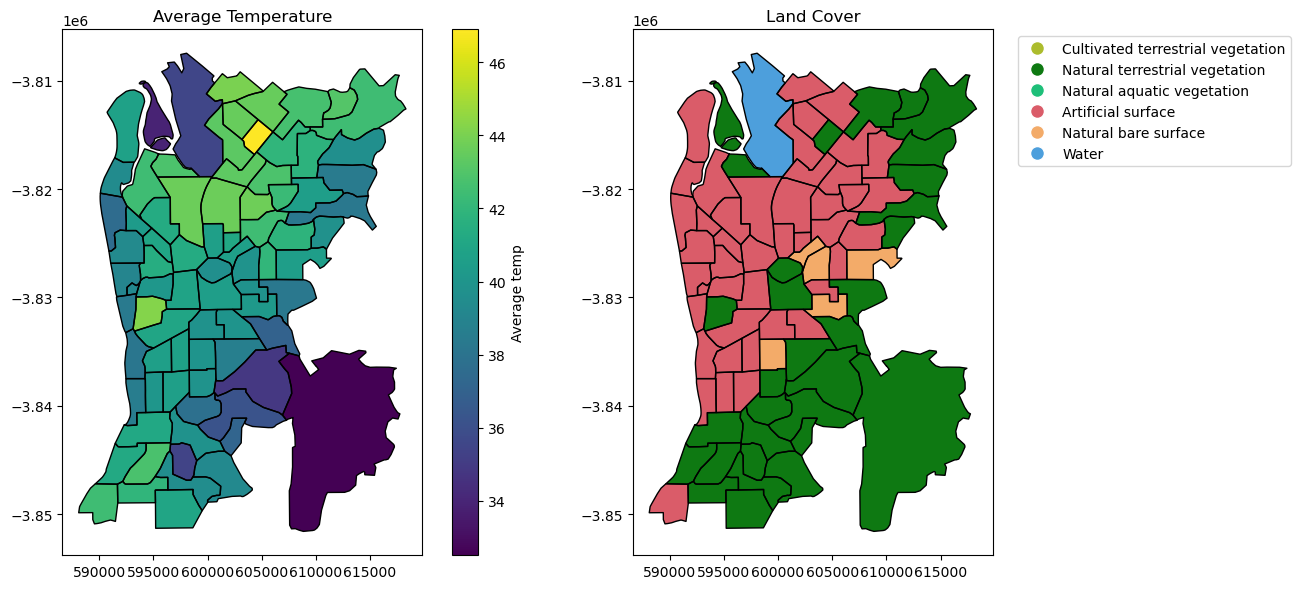

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

gdf_clipped.plot(ax=ax1, column='avg_temperature', cmap='viridis', legend=True, legend_kwds={"label": "Average temp"})
gdf_clipped.boundary.plot(ax=ax1, color='black', linewidth=1)
ax1.set_title('Average Temperature')

gdf_clipped.plot(ax=ax2, column='most_common_land_cover', cmap=cmap, norm=norm, legend=False)
gdf_clipped.boundary.plot(ax=ax2, color='black', linewidth=1)
ax2.set_title('Land Cover')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_list[i], markersize=10, label=landcover_colour_scheme[key][4])
                   for i, key in enumerate(landcover_colour_scheme) if key != 0]  # Exclude 'No Data'

ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Plot relationship 

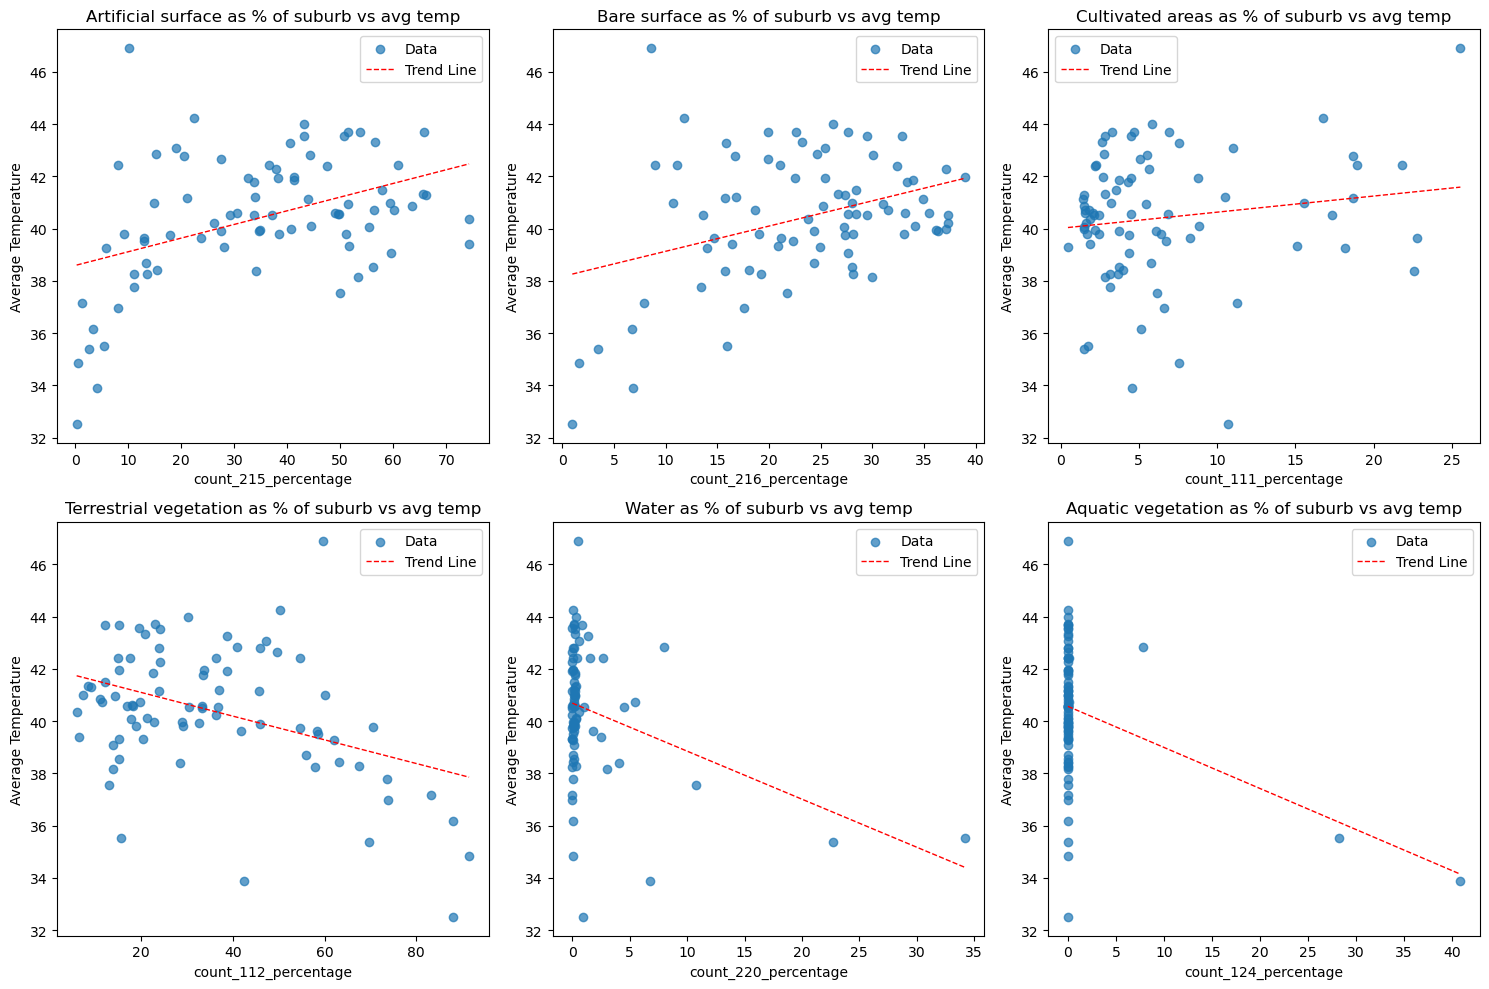

In [22]:
land_cover_columns = ['count_111', 'count_112', 'count_124', 'count_215', 'count_216', 'count_220']

for col in land_cover_columns:
    percentage_col = col + '_percentage'
    gdf_clipped[percentage_col] = (gdf_clipped[col] * (25**2) / 1_000_000 / gdf_clipped['AREASQKM21']) * 100


land_cover_classes = ['count_215_percentage', 'count_216_percentage', 'count_111_percentage', 'count_112_percentage', 'count_220_percentage', 'count_124_percentage']

titles = [
    'Artificial surface as % of suburb vs avg temp',
    'Bare surface as % of suburb vs avg temp',
    'Cultivated areas as % of suburb vs avg temp',
    'Terrestrial vegetation as % of suburb vs avg temp',
    'Water as % of suburb vs avg temp',
    'Aquatic vegetation as % of suburb vs avg temp'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10)) 
axes = axes.flatten() 

for i, (land_cover_class, title) in enumerate(zip(land_cover_classes, titles)):
    ax = axes[i]
    ax.scatter(gdf_clipped[land_cover_class], gdf_clipped['avg_temperature'], alpha=0.7, label='Data')
    x = gdf_clipped[land_cover_class]
    y = gdf_clipped['avg_temperature']
    coeffs = np.polyfit(x, y, 1)
    trend_line = np.poly1d(coeffs)
    x_range = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_range, trend_line(x_range), color='red', linestyle='--', linewidth=1, label='Trend Line')
    ax.set_title(title)
    ax.set_xlabel(f'{land_cover_class}')
    ax.set_ylabel('Average Temperature')
    ax.legend()
plt.tight_layout() 
plt.show()